In [1]:
import emcee
import sys
import numpy as np
import matplotlib.pyplot as plt
import corner
from scipy.optimize import minimize

In [2]:
sys.path.append('../')

In [3]:
from quest import Reconstruction

In [14]:
myrec = Reconstruction.from_ini('LB_FG2.ini')

DATABASE: loaded
SIMUALATION object with  FG: Loaded
FILTERING object with  FG: Loaded
QUEST object with  FG: Loaded


In [15]:
class Likelihood:

    def __init__(self, rec_lib):
        self.rec = rec_lib
    
    @classmethod
    def from_ini(cls, ini_file):
        rec = Reconstruction.from_ini(ini_file)
        return cls(rec)
    
    def get_theory(self,alen):
        return self.rec.cl_pp * alen * self.rec.Lfac
    
    def get_theory_binned(self,alen):
        return self.rec.bin_cell(self.get_theory(alen))
    
    def get_data(self):
        return self.rec.get_qcl_wR_stat(n=400,ret='cl',n1=True,rdn0=True)
    
    def get_mean_spectra(self):
        return self.get_data().mean(axis=0)

    def get_covariance(self):
        return np.cov(self.get_data().T)

    def get_chisq(self,alen):
        theory = self.get_theory_binned(alen)
        data = self.get_mean_spectra()
        cov = self.get_covariance()
        vect = theory - data
        return np.dot(vect, np.dot(np.linalg.inv(cov), vect.T))
    
    def lnlike(self,alen):
        return -0.5 * self.get_chisq(alen)
    
    def lnprior(self,alen):
        if 0.5 < alen < 1.5:
            return 0.0
        return -np.inf
    
    def lnprob(self,alen):
        lp = self.lnprior(alen)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.lnlike(alen)

    def MLE(self):
        nll = lambda *args: -self.lnlike(*args)
        initial = np.array([1]) + 0.1 * np.random.randn(1)
        soln = minimize(nll, initial)
        if soln.success:
            return soln.x
        else:
            raise ValueError(soln.message)

    def sampler(self, nwalkers=32, nburn=100, nsteps=1000):
        mle = np.array([1.01136254])
        ndim = 1
        pos = [mle + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnprob)
        sampler.run_mcmc(pos, nsteps,progress=True)
        samples = sampler.get_chain(discard=100, thin=15, flat=True)
        
        return samples




In [16]:
mylik = Likelihood(myrec)

In [17]:
mylik.MLE()

array([1.01384752])

In [18]:
s = mylik.sampler()

100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


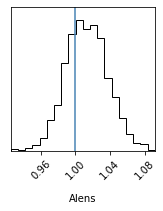

In [19]:
fig = corner.corner(s, labels=['Alens'], truths=[1])


In [10]:
from IPython.display import display, Math

In [13]:
labels = ['Alens']
for i in range(1):
    mcmc = np.percentile(s[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>